### evalute dataset

In [1]:
import tensorflow as tf
val_ds_list = [tf.data.experimental.SqlDataset(
            'sqlite', '/data/robert/training/p1-dip-metadata.db', 
            f"""select path, degree, label from metadata 
            where ( label = 'OK' or label = 'NG' ) and 
            ( component_class = 'label' or
            component_class = 'heat_sink' or
            component_class = 'screw' ) 
            """, (tf.string, tf.string, tf.string))]
print([i for i,_ in enumerate(val_ds_list[0])][-1] + 1)

53194


In [2]:
import tensorflow as tf
for label in ["NG", "OK"]:
    for component in ["label", "heat_sink", "screw"]:
        ds = tf.data.experimental.SqlDataset(
            'sqlite', '/data/robert/training/p1-dip-metadata.db', 
            f"""select path, degree, label from metadata 
            where label = '{label}' and 
            component_class = '{component}'
            """, (tf.string, tf.string, tf.string))
        print(component, label, [i for i,_ in enumerate(ds)][-1] + 1)

label NG 1228
heat_sink NG 127
screw NG 144
label OK 21898
heat_sink OK 24239
screw OK 5558


In [5]:
def parse_example(example_proto):    
    image_feature_description = {
        "path": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
    }
    features_in_example = tf.io.parse_single_example(example_proto, image_feature_description)
    features = {
        'image': features_in_example['image'],
        'label': features_in_example['label'],
    }
    return features

In [5]:
# unlabeled
def ng_parse_func(path):
    features = {
        'image': parse_img(tf.io.read_file(path)),
        'label': label_to_onehot(tf.constant('NG')),
    }
    label = features['label']
    return features, label
def ok_parse_func(path):
    features = {
        'image': parse_img(tf.io.read_file(path)),
        'label': label_to_onehot(tf.constant('OK')),
    }
    label = features['label']
    return features, label
import glob
hs_ok = glob.glob('/data/aoi-wzs-p1-dip-fa-nvidia/unlabeled-labeled-on-20200928/OK/HS/*')
hs_ng = glob.glob('/data/aoi-wzs-p1-dip-fa-nvidia/unlabeled-labeled-on-20200928/NG/HS/*')
sc_ok = glob.glob('/data/aoi-wzs-p1-dip-fa-nvidia/unlabeled-labeled-on-20200928/OK/Screw/*')
sc_ng = glob.glob('/data/aoi-wzs-p1-dip-fa-nvidia/unlabeled-labeled-on-20200928/NG/Screw/*')
ok_ds = tf.data.Dataset.from_tensor_slices(hs_ok+sc_ok)
ng_ds = tf.data.Dataset.from_tensor_slices(hs_ng+sc_ng)
print([i for i,_ in enumerate(ok_ds)][-1] + 1)
print([i for i,_ in enumerate(ng_ds)][-1] + 1)
ok_test_ds = ok_ds.map(ok_parse_func, tf.data.experimental.AUTOTUNE).batch(512)
ng_test_ds = ng_ds.map(ng_parse_func, tf.data.experimental.AUTOTUNE).batch(512)

354
59


## load & test ori one

In [1]:
import tensorflow as tf
# LABEL_CLASS_LIST = ['NG', 'OK']
LABEL_CLASS_LIST = ['000', '090', '180', '270', 'NG']
label_lookup = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(LABEL_CLASS_LIST, tf.constant([i for i in range(len(LABEL_CLASS_LIST))], dtype=tf.int64)), -1)
def parse_img(img):
#     img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32, expand_animations = False)
    img = tf.io.decode_jpeg(img,channels=1,dct_method='INTEGER_ACCURATE',try_recover_truncated=True)
    img = tf.cast(img, dtype=tf.dtypes.float32) / 255.0
    img = tf.image.resize_with_pad(img, 640, 640)
    return img
def label_to_onehot(label):
    label = label_lookup.lookup(label)
    label = tf.one_hot(label, len(LABEL_CLASS_LIST))
    # label = tf.cast(label, dtype=tf.float32)
    return label
def test_parse_func(data):
    features = {
        'image': parse_img(tf.io.read_file(data[0])),
        'label': label_to_onehot(data[1]),
    }
    label = features['label']
    return features, label
def test_ds_to_eva(test_ds, batch_size=32):
    return test_ds.map(test_parse_func, tf.data.experimental.AUTOTUNE).batch(batch_size)

In [2]:
# ! pip install mysql-connector-python-rf
import mysql.connector
mydb = mysql.connector.connect(
  host="10.41.241.230",
  port="30003",
  user="aoi_ai",
  password="finding_way_out",
  database="P1"
)
c = mydb.cursor()
c.execute("SELECT path, degree FROM dip_fa where component='label' and label='OK'")
test = c.fetchall()
test_ds = tf.data.Dataset.from_tensor_slices(test)
print([i for i,_ in enumerate(test_ds)][-1] + 1)
c.execute("SELECT path, label FROM dip_fa where component='label' and label='NG'")
ng = c.fetchall()
ng_ds = tf.data.Dataset.from_tensor_slices(ng)
test_ds = test_ds.concatenate(ng_ds)
print([i for i,_ in enumerate(test_ds)][-1] + 1)
eva_test_ds = test_ds_to_eva(test_ds)

22891
24229


In [ ]:
### import neural_structured_learning as nsl
def model_structure(model, input_shape, label_num):
    inputs = {
        'image': tf.keras.Input(input_shape, name='image'),
    }

    x = inputs['image']

    if model == "I3":
        model_body = tf.keras.applications.InceptionV3(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "M2":
        model_body = tf.keras.applications.MobileNetV2(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "M":
        model_body = tf.keras.applications.MobileNet(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "R2":
        model_body = tf.keras.applications.ResNet50V2(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "R":
        model_body = tf.keras.applications.ResNet50(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "D":
        model_body = tf.keras.applications.DenseNet121(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "I3V2":
        model_body = tf.keras.applications.InceptionResNetV2(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "V":
        model_body = tf.keras.applications.VGG16(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "X":
        model_body = tf.keras.applications.Xception(input_shape=input_shape, 
            include_top=False, weights=None)

    x = model_body(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, name='dense_128')(x)
    x = tf.keras.layers.Dense(label_num, name='dense_logits')(x)
    x = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
model = model_structure('M2', (224,224,3), len(LABEL_CLASS_LIST))
adv_config = nsl.configs.make_adv_reg_config(multiplier=2e-1, 
                                                    adv_step_size=2e-1, 
                                                    adv_grad_norm = 'infinity')
adv_model = nsl.keras.AdversarialRegularization(model, 
                                                label_keys=['label'], 
                                                adv_config=adv_config)

In [2]:
import neural_structured_learning as nsl
import tensorflow as tf
import tensorflow.keras.layers as ly
def SomeConv(conv_count, first_filter, kernel_size, strides, input_shape, degree_num, maxpool=False):
    input_image = tf.keras.Input(input_shape, name='image')
    # inputs = tf.keras.Input(shape=(), dtype=tf.string, name='input')
    # x = ly.Lambda(lambda img : tf.map_fn(decode_img, img, dtype=tf.float32))(inputs)
    # # x = tf.map_fn(decode_img, inputs, dtype=tf.float32)
    x = input_image
    for i in range(conv_count):
        x = ly.Conv2D(first_filter*(i+1), kernel_size, (strides, strides), 
                      padding='same', name='conv'+str(i+1), activation=tf.nn.relu)(x)
        x = ly.BatchNormalization()(x)
        if maxpool and i < conv_count - 1:
            x = ly.MaxPool2D()(x)
    x = ly.GlobalAveragePooling2D(name='GAP')(x)
    # for num_units in hparams.num_fc_units:
    #   x = tf.keras.layers.Dense(num_units, activation='relu')(x)
    x = ly.Dense(degree_num, name='dense_logits')(x)
    x = ly.Activation('softmax', dtype='float32', name='predictions')(x)
    return tf.keras.Model(inputs=input_image, outputs=x)

# model = SomeConv(3, 16, 5, 2, (640, 640, 1), 5, True)
model = SomeConv(3, 32, 5, 1, (640, 640, 1), 5, True)
adv_config = nsl.configs.make_adv_reg_config(multiplier=2e-1, 
                                                    adv_step_size=2e-1, 
                                                    adv_grad_norm = 'infinity')
adv_model = nsl.keras.AdversarialRegularization(model, 
                                                label_keys=['label'], 
                                                adv_config=adv_config)

In [3]:
# METRICS = [
#             tf.keras.metrics.CategoricalAccuracy(name='acc'),
#             tf.keras.metrics.Precision(name="precision/ok", class_id=1),
#             tf.keras.metrics.Precision(name="precision/ng", class_id=0),
#             tf.keras.metrics.Recall(name="recall/ok", class_id=1),
#             tf.keras.metrics.Recall(name="recall/ng", class_id=0),
#         ]
METRICS = [
            tf.keras.metrics.CategoricalAccuracy(name='acc'),
            tf.keras.metrics.Precision(name="precision/000", class_id=0),
            tf.keras.metrics.Precision(name="precision/090", class_id=1),
            tf.keras.metrics.Precision(name="precision/180", class_id=2),
            tf.keras.metrics.Precision(name="precision/270", class_id=3),
            tf.keras.metrics.Precision(name="precision/NG", class_id=4),
            tf.keras.metrics.Recall(name="recall/000", class_id=0),
            tf.keras.metrics.Recall(name="recall/090", class_id=1),
            tf.keras.metrics.Recall(name="recall/180", class_id=2),
            tf.keras.metrics.Recall(name="recall/270", class_id=3),
            tf.keras.metrics.Recall(name="recall/NG", class_id=4),
        ]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), 
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=METRICS)
adv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), 
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=METRICS)

### loop in a list of dir

In [106]:
test_base = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/'
import glob
def dir_parse_func(path):
    features = {
        'image': parse_img(tf.io.read_file(path)),
        'label': label_to_onehot(tf.strings.split(path, sep='/')[-2]),
    }
    label = features['label']
    return features, label
l_ng = glob.glob(f'{test_base}NG/*.jpg')
l_000 = glob.glob(f'{test_base}000/*.jpg')
l_090 = glob.glob(f'{test_base}090/*.jpg')
l_180 = glob.glob(f'{test_base}180/*.jpg')
l_270 = glob.glob(f'{test_base}270/*.jpg')
test_ds = tf.data.Dataset.from_tensor_slices(l_ng+l_000+l_090+l_180+l_270)
print([i for i,_ in enumerate(test_ds)][-1] + 1)
eva_test_ds = test_ds.map(dir_parse_func, tf.data.experimental.AUTOTUNE).batch(64)

22297


In [98]:
import glob, os
target_h5 = sorted(glob.glob('/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/pre_LABEL/*'))
# base = [target_h5[0]]
# target_h5 = base + target_h5[-10:]
for h in target_h5:
#     if h.split(os.path.sep)[-1].split('ep')[0] != 'rLRf-0.6302652256935692_lr-235.80424938238488' or h[-3:] != '.h5':
#         continue
    try:
        epo = int(h.split(os.path.sep)[-1].split('ep_')[-1][:3])
        if epo >= 0:
            print(h)
            model = adv_model.base_model 
            model.load_weights(h)
            evaluate = model.evaluate(eva_test_ds)
            named_results = dict(zip(model.metrics_names, evaluate))
            print(named_results)
    except:
        print(h)
        model = adv_model.base_model 
        model.load_weights(h)
        evaluate = model.evaluate(eva_test_ds)

/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/pre_LABEL/cc-3_ff-32_ks-5_s-1_mp-True_asz-0.09968-ep_061-vl_0.0063-va_0.9987.h5
21/21 [==============================] - 3s 141ms/step - loss: 0.0731 - acc: 0.9807 - precision/000: 0.9890 - precision/090: 0.9091 - precision/180: 0.9595 - precision/270: 0.9973 - precision/NG: 0.3889 - recall/000: 0.9914 - recall/090: 0.9091 - recall/180: 0.8765 - recall/270: 0.9817 - recall/NG: 1.0000
{'loss': 0.0731135830283165, 'acc': 0.9807395935058594, 'precision/000': 0.9889975786209106, 'precision/090': 0.9090909361839294, 'precision/180': 0.9594594836235046, 'precision/270': 0.9973474740982056, 'precision/NG': 0.3888888955116272, 'recall/000': 0.9914215803146362, 'recall/090': 0.9090909361839294, 'recall/180': 0.8765432238578796, 'recall/270': 0.9817232489585876, 'recall/NG': 1.0}
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/pre_LABEL/rLRf-0.631_lr-322_ep_47-vl_0.0016-va_0.9994.h5
21/21 [=============================

In [10]:
import glob
target_h5 = sorted(glob.glob('/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/preprocessed_0118_conv/cc-3_ff-8_ks-3_s-1_mp-True_lr-3_op-adam_adv-True/*'))
for h in target_h5:
    try:
        model.load_weights(h)
#         adv_model.load_weights(h)
#         adv_model.base_model.save_weights(h)
    except Exception as e:
        print(e)
        print(h)

You are trying to load a weight file containing 1 layers into a model with 7 layers.
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/preprocessed_0118_conv/cc-3_ff-8_ks-3_s-1_mp-True_lr-3_op-adam_adv-True/ep_001-vl_0.615766-va_0.817134.h5
You are trying to load a weight file containing 1 layers into a model with 7 layers.
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/preprocessed_0118_conv/cc-3_ff-8_ks-3_s-1_mp-True_lr-3_op-adam_adv-True/ep_002-vl_0.337697-va_0.908415.h5
You are trying to load a weight file containing 1 layers into a model with 7 layers.
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/preprocessed_0118_conv/cc-3_ff-8_ks-3_s-1_mp-True_lr-3_op-adam_adv-True/ep_003-vl_0.268622-va_0.927673.h5
You are trying to load a weight file containing 1 layers into a model with 7 layers.
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/preprocessed_0118_conv/cc-3_ff-8_ks-3_s-1_mp-True_lr-3_op-adam_adv-True/ep_004-vl_0.240244

In [5]:
import os
# (96,96,3)

h5s = [
#     '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/re_labeled_trans_r50/b-VGG16_lr-5_op-RMSprop_adv-True_ss-0.1472465226446634/ep_098-vl_0.013516-va_1.000000.h5',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/heatsink_screw/b-Xception_lr-3_op-SGD_adv-True_ss-0.015332968985510651/ep_089-vl_0.147938-va_0.997764.h5',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/heatsink_screw/b-Xception_lr-3_op-SGD_adv-True_ss-0.015332968985510651/final',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/heatsink_screw/b-Xception_lr-5_op-adam_adv-True_ss-0.08295303338298936/ep_067-vl_0.082664-va_0.971052.h5',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/heatsink_screw/b-VGG16_lr-3_op-SGD_adv-True_ss-0.12460417010975225/final',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/heatsink_screw/b-MobileNetV2_lr-3_op-SGD_adv-True_ss-0.1583760176604389/final',
]
for h5 in h5s:
    print(os.path.split(h5)[-1])
    init_model = tf.keras.models.load_model(h5)
    evaluate = init_model.evaluate(eva_test_ds)
    named_results = dict(zip(init_model.metrics_names, evaluate))
    named_results

ep_089-vl_0.147938-va_0.997764.h5
9/9 [==============================] - 7s 775ms/step - loss: 0.1479 - acc: 0.9976 - precision/ok: 0.9254 - precision/ng: 1.0000 - recall/ok: 1.0000 - recall/ng: 0.9976
final
9/9 [==============================] - 7s 738ms/step - loss: 0.1479 - acc: 0.9976 - precision/ok: 0.9254 - precision/ng: 1.0000 - recall/ok: 1.0000 - recall/ng: 0.9976
ep_067-vl_0.082664-va_0.971052.h5
9/9 [==============================] - 8s 910ms/step - loss: 0.0825 - acc: 0.9711 - precision/ok: 1.0000 - precision/ng: 0.9710 - recall/ok: 0.0081 - recall/ng: 1.0000
final
9/9 [==============================] - 7s 738ms/step - loss: 0.5996 - acc: 0.9708 - precision/ok: 0.0000e+00 - precision/ng: 0.9708 - recall/ok: 0.0000e+00 - recall/ng: 1.0000
final
9/9 [==============================] - 6s 686ms/step - loss: 0.6452 - acc: 0.9708 - precision/ok: 0.0000e+00 - precision/ng: 0.9708 - recall/ok: 0.0000e+00 - recall/ng: 1.0000


## Analysis

In [110]:
import numpy as np
import tensorflow as tf
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/heatsink_screw/b-Xception_lr-3_op-SGD_adv-True_ss-0.015332968985510651/final' #online 10/25
# screw
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/screw_withaug/b-VGG16_op-adam_lr--4_adv-True_ss-0.18726356572067965/ep_019-vl_0.003259-va_0.999590.h5' # -11/27 O66
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/SCREW/screw_vgg16_224_ep_200-vl_0.000044-va_1.000000.h5' # -12/10 O8 L2
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/SCREW/V-1211-ep_089-vl_2.0300e_08-va_1.0.h5'
# heatsink
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/HEAT_SINK/MobileNet_224_ss-0.18896-vl_0.003152-va_0.999941.h5' # -11/27 O6
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/HEAT_SINK/MobileNet-0.18896-20201127ep_020-vl_0.0-va_1.0.h5' # -12/10 O152, L9
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/aug_hs_1120/b-DenseNet121_op-adam_lr-3_adv-True_ss-0.1804724476360337/ep_046-vl_0.002008-va_0.999917.h5' # -11/27 O5 L1
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/HEAT_SINK/M_18896_after_1127-vl_3.8417e_06-va_1.0.h5'
# label
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/aug_label_1207/b-MobileNetV2_op-adam_lr-3_adv-True_ss-0.18402852477609083/ep_024-vl_0.028936-va_0.995117.h5' # -1209 O305 L4
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/aug_label_1207/b-DenseNet121_op-adam_lr-4_adv-True_ss-0.1804491434611859/ep_011-vl_0.041960-va_0.994324.h5' # -1209 O344 L3
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/LABEL/label_M2_18402_5e-7_ep_118-vl_0.0026-va_0.9996.h5' # -1209 O7
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/LABEL/ep_004-vl_0.000127-va_1.000000.h5'
# pre_LABEL
## conv
h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/pre_LABEL/cc-3_ff-32_ks-5_s-1_mp-True_asz-0.09968-ep_061-vl_0.0063-va_0.9987.h5' #O27L33 # O25
h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/pre_LABEL/tune_0125_ep_011-vl_0.0075-va_0.9982.h5' # O13L5 # O10
h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/pre_LABEL/rLRf-0.654_lr-469_ep_11-vl_0.0063-va_0.9988.h5' #O13 #O6
# h5 = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/pre_LABEL/rLRf-0.631_lr-322_ep_47-vl_0.0016-va_0.9994.h5' #O7L4 #O6
# init_model = tf.keras.models.load_model(h5)
model.load_weights(h5)
def parse_func(data):
    features = {
        'image': parse_img(tf.io.read_file(data[0])),
        'label': label_to_onehot(data[1]),
    }
    return features, features['label'], data[0]

def cm_dir_parse_func(path):
    features = {
        'image': parse_img(tf.io.read_file(path)),
        'label': label_to_onehot(tf.strings.split(path, sep='/')[-2]),
    }
    label = features['label']
    return features, label, path

pre_ds = test_ds.map(cm_dir_parse_func, tf.data.experimental.AUTOTUNE)
outcome_dict = {'OK':[], 'NG':[], 'Overkill':[], 'Leak':[]}
for i, l, p in pre_ds.batch(1024):
    pre = model.predict(i)
    for_range = i['image'].shape[0]
    for idx in range(for_range):
        fp = p[idx].numpy().decode()
        # label
        if np.argmax(l[idx].numpy()) == 4 and np.argmax(l[idx].numpy()) != np.argmax(pre[idx]):
            outcome_dict['Leak'].append([fp, LABEL_CLASS_LIST[np.argmax(pre[idx])], LABEL_CLASS_LIST[np.argmax(l[idx].numpy())]])
        elif np.argmax(l[idx].numpy()) == 4 and np.argmax(l[idx].numpy()) == np.argmax(pre[idx]):
            outcome_dict['NG'].append([fp, LABEL_CLASS_LIST[np.argmax(pre[idx])], LABEL_CLASS_LIST[np.argmax(l[idx].numpy())]])
        elif np.argmax(l[idx].numpy()) != np.argmax(pre[idx]):
            outcome_dict['Overkill'].append([fp, LABEL_CLASS_LIST[np.argmax(pre[idx])], LABEL_CLASS_LIST[np.argmax(l[idx].numpy())]])
        else:
            outcome_dict['OK'].append([fp, LABEL_CLASS_LIST[np.argmax(pre[idx])], LABEL_CLASS_LIST[np.argmax(l[idx].numpy())]])
        # heatsink, screw
#         if np.argmax(l[idx].numpy()) == 0 and np.argmax(pre[idx]) == 0:
#             outcome_dict['NG'].append([fp, LABEL_CLASS_LIST[np.argmax(pre[idx])], LABEL_CLASS_LIST[np.argmax(l[idx].numpy())]])
#         elif np.argmax(l[idx].numpy()) == 1 and np.argmax(pre[idx]) == 1:
#             outcome_dict['OK'].append([fp, LABEL_CLASS_LIST[np.argmax(pre[idx])], LABEL_CLASS_LIST[np.argmax(l[idx].numpy())]])
#         elif np.argmax(l[idx].numpy()) == 0 and np.argmax(pre[idx]) == 1:
#             outcome_dict['Leak'].append([fp, LABEL_CLASS_LIST[np.argmax(pre[idx])], LABEL_CLASS_LIST[np.argmax(l[idx].numpy())]])
#         elif np.argmax(l[idx].numpy()) == 1 and np.argmax(pre[idx]) == 0:
#             outcome_dict['Overkill'].append([fp, LABEL_CLASS_LIST[np.argmax(pre[idx])], LABEL_CLASS_LIST[np.argmax(l[idx].numpy())]])

for k in outcome_dict.keys():
    print(k, len(outcome_dict[k]))

OK 22119
NG 165
Overkill 13
Leak 0


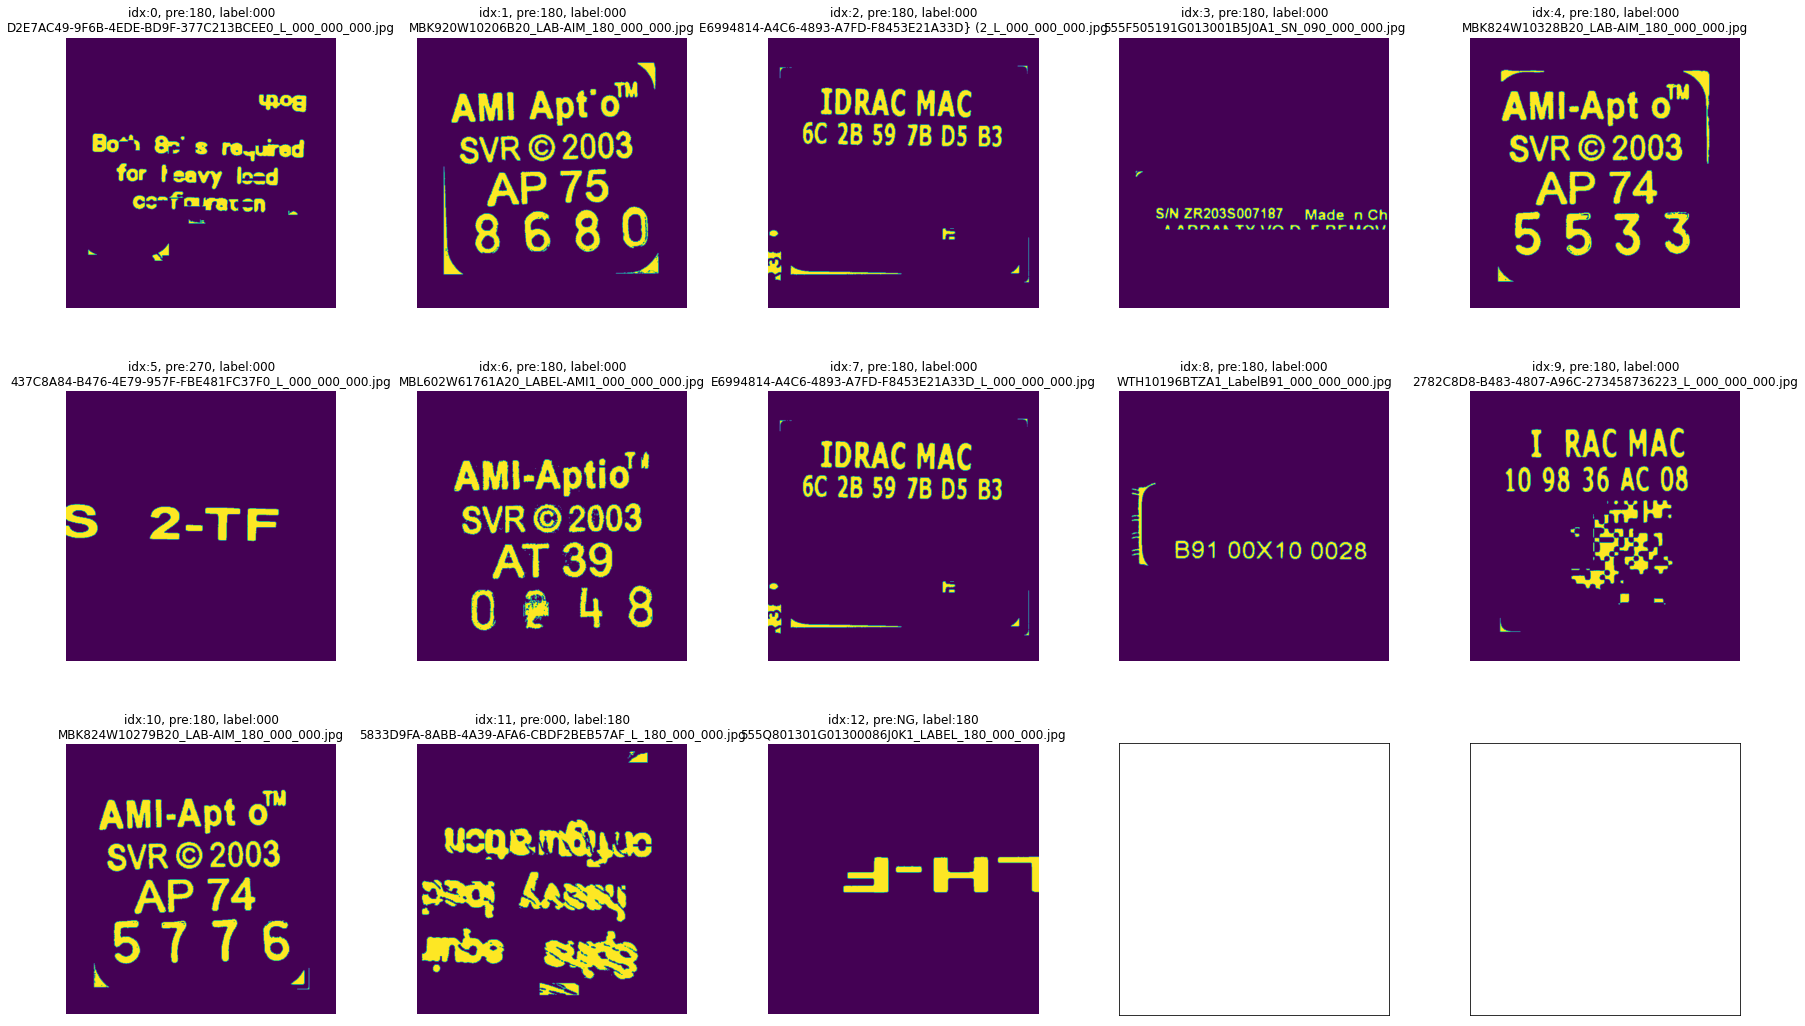

In [111]:
x = outcome_dict['Overkill']
import os
import matplotlib.pyplot as plt
from PIL import Image
# h = 100
h = int(len(x)/5)+1
fig_h = h * 6
startofx = 0
%matplotlib inline
fig, axes = plt.subplots(h, 5, figsize=(30, fig_h), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for idx, (ax, value) in enumerate(zip(axes.flat, x[startofx:])):
    try:
        ax.imshow(parse_img(tf.io.read_file(value[0])))
#         ax.imshow(Image.open(value[0]), cmap='gray')
        ax.set_title(f'idx:{startofx+idx}, pre:{value[1]}, label:{value[2]}\n{os.path.split(value[0])[1]}')
        ax.axis('off')
    except Exception as e:
        print(e)

### if labeling exists wrong

##### alter mysql 

In [30]:
# ! pip install mysql-connector-python-rf
import mysql.connector

mydb = mysql.connector.connect(
  host="10.41.241.230",
  port="30003",
  user="aoi_ai",
  password="finding_way_out",
  database="P1"
)

c = mydb.cursor()

In [31]:
idx_unchanged = []
d000 = [0, 1, 2, 36, 55, 56, 58, 59, 61, 62, 63, 64, 66, 67, 68, 69, 71, 72, 73]
d270 = [3, 13, 24, 35, 37, 38, 45, 54, 57, 60, 65, 70]
for idx, l in enumerate(outcome_dict['Leak']):
    filename = os.path.split(l[0])[-1]
    if idx in idx_unchanged:
        continue
    elif idx <= 12 and idx >= 4:
        sql = f"UPDATE dip_fa SET online_test='Overkill',label='OK',degree='000' WHERE filename='{filename}'"
    elif idx <= 23 and idx >= 14:
        sql = f"UPDATE dip_fa SET online_test='Overkill',label='OK',degree='000' WHERE filename='{filename}'"
    elif idx <= 34 and idx >= 25:
        sql = f"UPDATE dip_fa SET online_test='Overkill',label='OK',degree='000' WHERE filename='{filename}'"
    elif idx <= 44 and idx >= 39:
        sql = f"UPDATE dip_fa SET online_test='Overkill',label='OK',degree='000' WHERE filename='{filename}'"
    elif idx <= 53 and idx >= 46:
        sql = f"UPDATE dip_fa SET online_test='Overkill',label='OK',degree='000' WHERE filename='{filename}'"
    elif idx in d000:
        sql = f"UPDATE dip_fa SET online_test='Overkill',label='OK',degree='000' WHERE filename='{filename}'"
    elif idx in d270:
        sql = f"UPDATE dip_fa SET online_test='Overkill',label='OK',degree='270' WHERE filename='{filename}'"
    else:
        continue
    c.execute(sql)
    mydb.commit()

In [32]:
mydb.close()

##### alter files

In [96]:
import shutil, os
base_dir = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/jan_test/'
idx_unchanged = []
rm = []
NG = []
d000 = []
d090 = []
d180 = []
d270 = []
follow_pre = [0, 1, 2]
for idx, l in enumerate(outcome_dict['Leak']):
    filename = os.path.split(l[0])[-1]
    if idx in idx_unchanged:
        continue
    elif idx in d000:
        shutil.move(l[0], os.path.join(f'{base_dir}000/', os.path.split(l[0])[1]))
    elif idx in d090:
        shutil.move(l[0], os.path.join(f'{base_dir}090/', os.path.split(l[0])[1]))
    elif idx in d180:
        shutil.move(l[0], os.path.join(f'{base_dir}180/', os.path.split(l[0])[1]))
    elif idx in d270:
        shutil.move(l[0], os.path.join(f'{base_dir}270/', os.path.split(l[0])[1]))
    elif idx in NG:
        shutil.move(l[0], os.path.join(f'{base_dir}NG/', os.path.split(l[0])[1]))
    elif idx in follow_pre:
        shutil.move(l[0], os.path.join(f'{base_dir}{l[1]}/', os.path.split(l[0])[1]))
    elif idx in rm:
        os.remove(l[0])
    else:
        continue

#### pb output & test

In [140]:
for t in outcome_dict['Overkill']:
    shutil.copyfile(t[0], os.path.join('/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/test/', os.path.split(t[0])[-1]))
    print(t[0])

/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/4906AA8B-9AC8-417E-B41B-DBF798025F69_L_000_000_000.jpg
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/BB7124BE-CB75-4890-83E1-99FFEDC395B5_L_000_000_000.jpg
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/J4052030ZA1_LABELCE_000_000_000.jpg
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/MBK806W10131A80_LABEL-AMI_000_000_000.jpg
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/7DAE6FC0-E5ED-4612-987E-8AB74B21F1D6_L_000_000_000.jpg
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/J60510A8ZA1_LABEL_000_000_000.jpg
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/555F520007G04500201J0C1_LMAC_0

In [112]:
tf.saved_model.save(model, '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/exported/20210126')
# model.save('/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/exported/20210120')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/exported/20210126/assets


In [113]:
# imported = tf.saved_model.load('/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/exported/20210120')
imported = tf.keras.models.load_model('/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/exported/20210126')
infer = imported.signatures["serving_default"]
imported, infer.structured_outputs

(<tensorflow.python.keras.engine.functional.Functional at 0x7f9881961da0>,
 {'predictions': TensorSpec(shape=(None, 5), dtype=tf.float32, name='predictions')})

In [114]:
def test_func(path):
    features = {
        'image': parse_img(tf.io.read_file(path)),
    }
    return features
dirs = [
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/4906AA8B-9AC8-417E-B41B-DBF798025F69_L_000_000_000.jpg',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/BB7124BE-CB75-4890-83E1-99FFEDC395B5_L_000_000_000.jpg',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/J4052030ZA1_LABELCE_000_000_000.jpg',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/MBK806W10131A80_LABEL-AMI_000_000_000.jpg',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/7DAE6FC0-E5ED-4612-987E-8AB74B21F1D6_L_000_000_000.jpg',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/J60510A8ZA1_LABEL_000_000_000.jpg',
    '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/555F520007G04500201J0C1_LMAC_000_000_000.jpg',
]

to_test = tf.data.Dataset.from_tensor_slices(tf.constant(dirs)).map(test_func, tf.data.experimental.AUTOTUNE).batch(len(dirs))
# print([i for i,_ in enumerate(to_test)][-1] + 1)
pr = imported.predict(to_test)
for idx, pp in enumerate(pr):
    print(dirs[idx])
    print('pred_class: ', LABEL_CLASS_LIST[np.argmax(pp)])
    print('confidence: ', float(np.max(pp)))

/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/4906AA8B-9AC8-417E-B41B-DBF798025F69_L_000_000_000.jpg
pred_class:  000
confidence:  1.0
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/BB7124BE-CB75-4890-83E1-99FFEDC395B5_L_000_000_000.jpg
pred_class:  000
confidence:  0.9937283992767334
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/J4052030ZA1_LABELCE_000_000_000.jpg
pred_class:  000
confidence:  0.9995762705802917
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/MBK806W10131A80_LABEL-AMI_000_000_000.jpg
pred_class:  000
confidence:  0.9791553616523743
/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/000/7DAE6FC0-E5ED-4612-987E-8AB74B21F1D6_L_000_000_000.jpg
pred_class:  000
confidence:  0.9901185631752014
/data/aoi-wzs-p1-dip-fa-nvidia/l

### totfrecord

In [58]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(value):
    features = {
#         "image": _bytes_feature(tf.io.read_file(value[0]).numpy()),
        "path": _bytes_feature(tf.constant(value[0]).numpy()),
        "label": _bytes_feature(tf.constant(value[2]).numpy()),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=features))
    return example_proto.SerializeToString()

target = ['Leak', 'Overkill', 'OK', 'NG']
# target = ['Overkill', 'Leak']
# target = ['NG']
tfrecord_filepath = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/to_tune/jan.tfrecord'
with tf.io.TFRecordWriter(tfrecord_filepath) as writer:
    for key, value in outcome_dict.items():
        if key not in target:
            continue
        for v in value:
            example = serialize_example(v)
            writer.write(example)
print('Exported Successfully to '+tfrecord_filepath)

Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/to_tune/jan.tfrecord


In [50]:
for l in ['000', '090', '180', '270']:
    tfrecord_filepath = f'/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/to_tune/{l}.tfrecord'
    with tf.io.TFRecordWriter(tfrecord_filepath) as writer:
        for key, value in outcome_dict.items():
            if key != 'OK':
                continue
            for v in value:
                if v[2] != l:
                    continue
                example = serialize_example(v)
                writer.write(example)
    print('Exported Successfully to '+tfrecord_filepath)

Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/to_tune/000.tfrecord
Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/to_tune/090.tfrecord
Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/to_tune/180.tfrecord
Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/to_tune/270.tfrecord


In [59]:
tfrecord_base = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/to_tune/'
AUTOTUNE = tf.data.experimental.AUTOTUNE
def parse_example(example_proto):    
    image_feature_description = {
        "path": tf.io.FixedLenFeature([], tf.string),
#         "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
    }
    features_in_example = tf.io.parse_single_example(example_proto, image_feature_description)
    features = {
        'path': features_in_example['path'],
#         'image': features_in_example['image'],
        'label': features_in_example['label'],
    }
    return features

for tfr in os.listdir(tfrecord_base):
    ds = tf.data.TFRecordDataset(f'{tfrecord_base}{tfr}').map(parse_example, AUTOTUNE)
    print(tfr, [i for i,_ in enumerate(ds)][-1] + 1)

000.tfrecord 15855
180.tfrecord 2532
valid.tfrecord 55
090.tfrecord 1702
jan_valid.tfrecord 19
jan.tfrecord 751
NG.tfrecord 132
270.tfrecord 2021


#### move to target folder, for servable testing pred_class

In [8]:
# move to target folder, for servable testing pred_class
import os
from shutil import copyfile
target = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/totest/evaluate/'
for key, value in outcome_dict.items():
    if len(value) == 0:
        continue
    target_dir = os.path.join(target,key)
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for v in value:
        fn = f"{v[2]}+{os.path.split(v[0])[-1]}"
        copyfile(v[0], os.path.join(target_dir,fn))

### retrain overkill/leak

In [70]:
import os
def tune_parse_func(tup):
    features = {
        'image': parse_img(tf.io.read_file(tup[0])),
        'label': label_to_onehot(tup[2]),
    }
    label = features['label']
    return features, label
# def class_func(features, label):
#     return label
overkill_paths_ds = tf.data.Dataset.from_tensor_slices(outcome_dict['Overkill'])
leak_paths_ds = tf.data.Dataset.from_tensor_slices(outcome_dict['Leak'])
ok_paths_ds = tf.data.Dataset.from_tensor_slices(outcome_dict['OK'])
ng_paths_ds = tf.data.Dataset.from_tensor_slices(outcome_dict['NG'])
AUTOTUNE = tf.data.experimental.AUTOTUNE

# take & skip
# all_mapped_ds = [ok_paths_ds.map(ok_parse_func, tf.data.experimental.AUTOTUNE).repeat(), ng_paths_ds.map(ng_parse_func, tf.data.experimental.AUTOTUNE).repeat(), overkill_paths_ds.map(ok_parse_func, tf.data.experimental.AUTOTUNE).repeat()]
# all_shuffled_ds = tf.data.experimental.sample_from_datasets(all_mapped_ds).shuffle(1000)
# train_ds = all_shuffled_ds.skip(15000).cache().batch(32).prefetch(tf.data.experimental.AUTOTUNE)
# val_ds = all_shuffled_ds.take(5000).repeat().cache().batch(32).prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = overkill_paths_ds.map(tune_parse_func, AUTOTUNE).concatenate(leak_paths_ds.map(tune_parse_func, AUTOTUNE))
# valid_ds = overkill_paths_ds.map(ok_parse_func, AUTOTUNE)
# shu_valid_ds = valid_ds.shuffle(48)
# valid_ds = shu_valid_ds.take(32).cache().batch(32).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.cache().batch(32).prefetch(AUTOTUNE)

train_ds = [ok_paths_ds.map(tune_parse_func, AUTOTUNE).repeat(), ng_paths_ds.map(tune_parse_func, AUTOTUNE).repeat()]
train_ds = tf.data.experimental.sample_from_datasets(train_ds,[0.5, 0.5]).shuffle(10000).take(20000)
train_ds = train_ds.cache().batch(32).prefetch(AUTOTUNE) 

# train_ds = ok_paths_ds.map(ok_parse_func, tf.data.experimental.AUTOTUNE).concatenate(ng_path_ds.map(ng_parse_func, tf.data.experimental.AUTOTUNE))
# resampler = tf.data.experimental.rejection_resample(class_func, target_dist=[0.5, 0.5])
# balanced_ds = train_ds.apply(resampler).map(lambda extra_label, features_and_label: features_and_label)
# for features, labels in balanced_ds.take(10):
#     print(labels.numpy())
# .shuffle(1000).cache().repeat().batch(16).prefetch(tf.data.experimental.AUTOTUNE)

trained_h5_dir = f'''/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/trained_h5/label_tune_M2_18402/'''
if not os.path.exists(trained_h5_dir):
    os.makedirs(trained_h5_dir)
callbacks = [
        tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, mode='min', 
                restore_best_weights=True,
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=trained_h5_dir+'ep_{epoch:03d}-vl_{val_loss:03f}-va_{val_acc:03f}.h5',
#             save_best_only=True,
            monitor='val_loss',
            mode='min',
            save_weights_only=True,
        ),
    ]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-5), 
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=METRICS)
training_history = model.fit(
                train_ds, 
                epochs=500, 
                validation_data=valid_ds, 
#                 steps_per_epoch=200,
                callbacks=callbacks,
                verbose=2 # 0 = silent, 1 = progress bar, 2 = one line per epoch
            )

Epoch 1/500
625/625 - 76s - loss: 0.0011 - acc: 0.9998 - precision/000: 0.9999 - precision/090: 1.0000 - precision/180: 0.9978 - precision/270: 1.0000 - precision/NG: 1.0000 - recall/000: 0.9999 - recall/090: 1.0000 - recall/180: 0.9989 - recall/270: 1.0000 - recall/NG: 0.9999 - val_loss: 5.0721 - val_acc: 0.0318 - val_precision/000: 0.0263 - val_precision/090: 0.0000e+00 - val_precision/180: 0.0000e+00 - val_precision/270: 0.1429 - val_precision/NG: 0.1250 - val_recall/000: 0.6000 - val_recall/090: 0.0000e+00 - val_recall/180: 0.0000e+00 - val_recall/270: 0.0333 - val_recall/NG: 0.2500
Epoch 2/500
625/625 - 73s - loss: 1.6998e-04 - acc: 0.9999 - precision/000: 0.9999 - precision/090: 1.0000 - precision/180: 1.0000 - precision/270: 1.0000 - precision/NG: 1.0000 - recall/000: 1.0000 - recall/090: 1.0000 - recall/180: 0.9989 - recall/270: 1.0000 - recall/NG: 1.0000 - val_loss: 2.6212 - val_acc: 0.2420 - val_precision/000: 0.0000e+00 - val_precision/090: 0.0000e+00 - val_precision/180: 0.

## Show Images

In [15]:
import sqlite3
conn = sqlite3.connect('/tf/robertnb/p1-dip-metadata.db')
c = conn.cursor()

In [36]:
c.execute(f"""select path from metadata 
              where (
                    component_class='screw' or
                    component_class='heat_sink') and
                    date < 20200503 and
                    label='NG'
          """)

paths = c.fetchall()
len(paths)

63

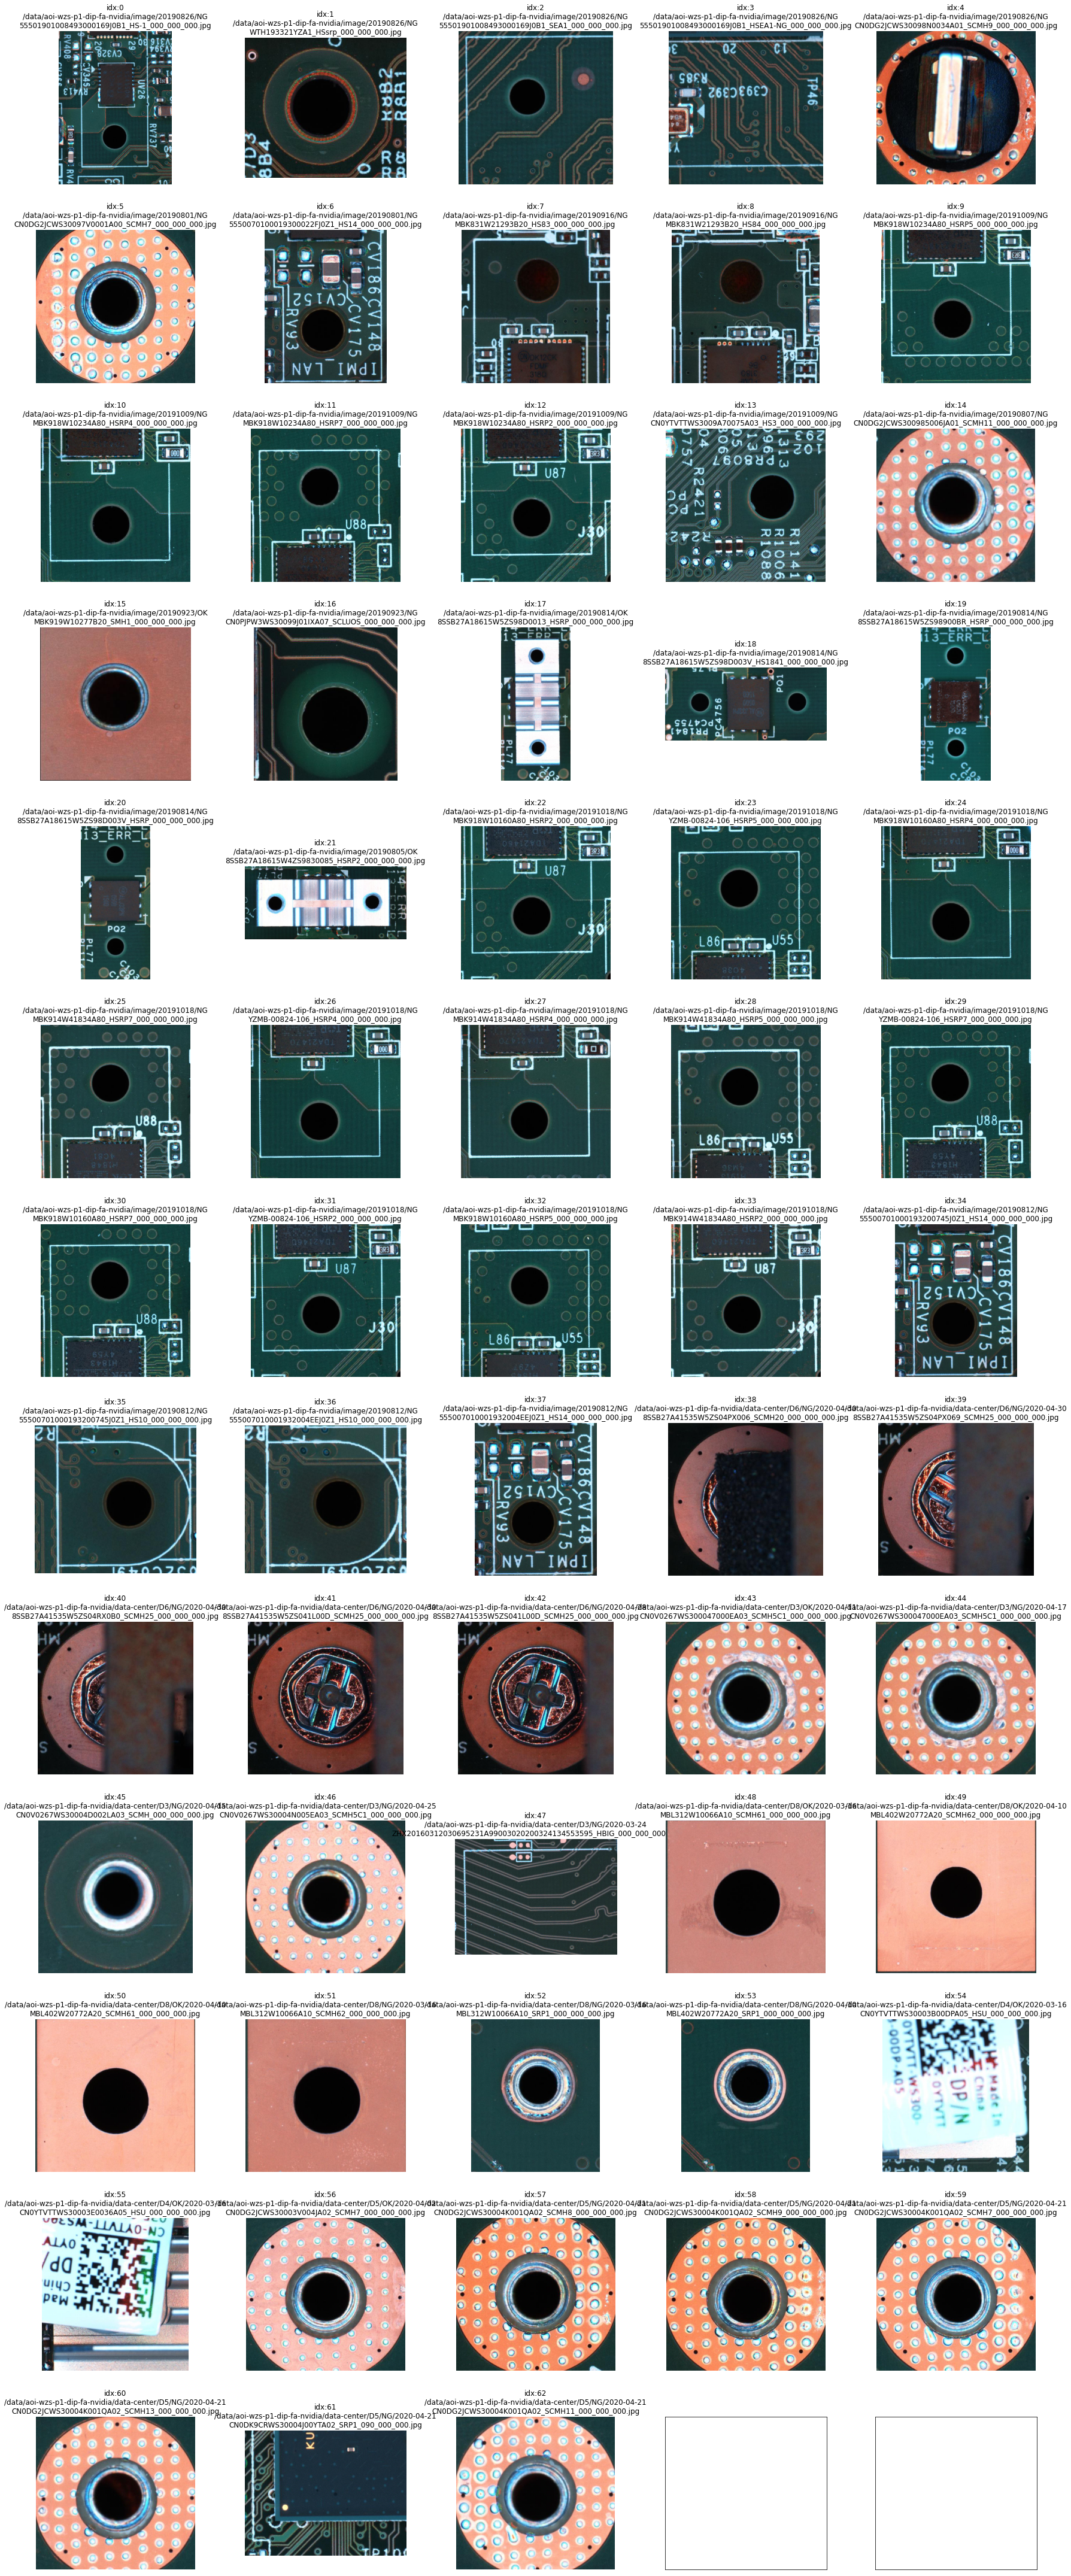

In [37]:
import os
import matplotlib.pyplot as plt
from PIL import Image
# h = 130
h = int(len(paths)/5)+1
fig_h = h * 6
startofx = 0
%matplotlib inline
fig, axes = plt.subplots(h, 5, figsize=(30, fig_h), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for idx, (ax, (value,)) in enumerate(zip(axes.flat, paths[startofx:])):
    try:
        ax.imshow(Image.open(value))
        ax.set_title(f'idx:{startofx+idx}\n{os.path.split(value)[0]}\n{os.path.split(value)[1]}')
        ax.axis('off')
    except Exception as e:
        print(e)
        
        